In [1]:
from tensorflow.keras import backend as K
K.clear_session()

# analiza i priprema

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

import hashlib
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms as trans
from PIL import Image

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/VII /DU/Christmas Cactus (Schlumbergera bridgesii)"

if os.path.exists(path):
    print(f"Folder '{path}' is successfully loaded.")
else:
    print(f"Folder '{path}' does not exist. Check the path.")

Folder '/content/drive/MyDrive/VII /DU/Christmas Cactus (Schlumbergera bridgesii)' is successfully loaded.


In [5]:
def calculate_image_hash(image_path):

    with open(image_path, 'rb') as f:
        img_data = f.read()
    return hashlib.sha256(img_data).hexdigest()

def find_duplicates(folder_path):

    hash_dict = defaultdict(list)

    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img_hash = calculate_image_hash(file_path)
                hash_dict[img_hash].append(file_path)
            except Exception as e:
                print(f"Greška pri čitanju fajla {file_path}: {e}")

    duplicates = {hash_value: paths for hash_value, paths in hash_dict.items() if len(paths) > 1}
    return duplicates

duplicates = find_duplicates(path)

if duplicates:
    print(f"Pronađeni su duplikati: ({len(duplicates)} različite grupe duplikata)")
    for i, (hash_value, paths) in enumerate(duplicates.items(), start=1):
        print(f"\nGrupa {i}:")
        for path in paths:
            print(f"  - {path}")
else:
    print("Nema duplikata u folderu.")

Nema duplikata u folderu.


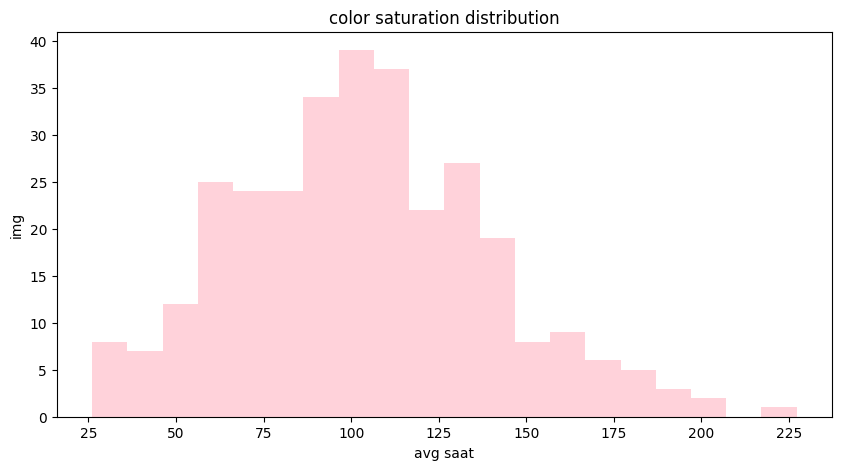

In [6]:
def analyze_saturation(folder_path):
    saturation_levels = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is not None:
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                saturation = hsv[:, :, 1]
                avg_saturation = np.mean(saturation)
                saturation_levels.append(avg_saturation)

    plt.figure(figsize=(10, 5))
    plt.hist(saturation_levels, bins=20, color='pink', alpha=0.7)
    plt.title("color saturation distribution")
    plt.xlabel("avg saat")
    plt.ylabel("img")
    plt.show()

analyze_saturation(path)

In [7]:
folder_path = path

def get_dominant_color(image, k=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    reshaped_image = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reshaped_image)
    return kmeans.cluster_centers_[0]

images = []
image_names = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(file_path)
        if img is not None:
            images.append(img)
            image_names.append(filename)

print(f"Loaded {len(images)} images.")

Loaded 306 images.


In [8]:
dominant_colors = [get_dominant_color(img) for img in images]

dataset = [(image_names[i], dominant_colors[i]) for i in range(len(dominant_colors))]

df = pd.DataFrame(dataset, columns=["Image Name", "Dominant Color"])
df["Dominant Color"] = df["Dominant Color"].apply(lambda x: list(map(int, x)))

csv_path = '/content/drive/My Drive/dominant_colors_dataset.csv'
df.to_csv(csv_path, index=False)
print(f"Dataset saved to {csv_path}.")


Dataset saved to /content/drive/My Drive/dominant_colors_dataset.csv.


In [9]:
df = pd.read_csv(csv_path)

image_paths = [os.path.join(path, name) for name in df["Image Name"]]
dominant_colors = np.array([eval(color) for color in df["Dominant Color"]])
normalized_colors = dominant_colors / 255.0

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing import image

In [11]:
def build_regression_model(base_model, name):
    inputs = base_model.input
    x = base_model.output
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(3, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name=name)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [12]:
def preprocess_images(image_paths, model_type):
    processed_images = []
    for img_path in image_paths:
        if model_type == "vgg" or model_type == "resnet":
            target_size = (224, 224)
        else:
            target_size = (299, 299)

        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        if model_type == "vgg":
            img_array = preprocess_input_vgg(img_array)
        elif model_type == "inception":
            img_array = preprocess_input_inception(img_array)
        elif model_type == "resnet":
            img_array = preprocess_input_resnet(img_array)
        processed_images.append(img_array)
    return np.vstack(processed_images)

In [13]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.legend()

    plt.show()

# VGG

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

images_vgg = preprocess_images(image_paths, model_type="vgg")

vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

vgg_regression = build_regression_model(vgg_model, "VGG16_Regression")

X_train_vgg, X_val_vgg, y_train, y_val = train_test_split(images_vgg, normalized_colors, test_size=0.2, random_state=42)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training VGG16 regression model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.2673 - mae: 0.4898 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - loss: 0.2687 - mae: 0.4924 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 0.2709 - mae: 0.4943 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - loss: 0.2717 - mae: 0.4941 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - loss: 0.2671 - mae: 0.4887 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - loss: 0.2720 - mae: 0.4940 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.2685 - mae: 0.4916 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 0.2735 - mae: 0.4973 - val_loss: 0.2646 - val_mae: 0.4922
Epoch 9/10
16/16 ━━━━━

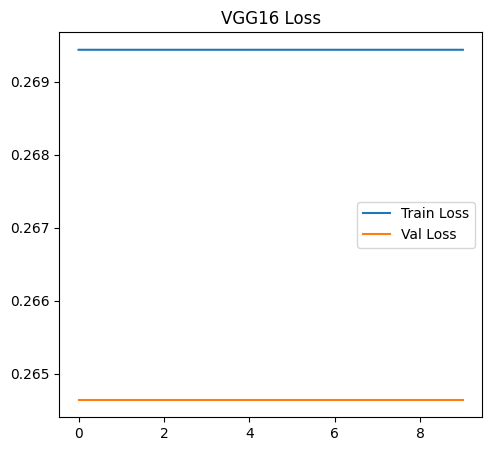

In [21]:
print("Training VGG16 regression model...")
history_vgg = vgg_regression.fit(X_train_vgg, y_train, validation_data=(X_val_vgg, y_val), epochs=10, batch_size=16)

vgg_loss, vgg_mae = vgg_regression.evaluate(X_val_vgg, y_val)

print(f"VGG16 - Loss: {vgg_loss}, Acc: {vgg_mae}")

plot_training_history(history_vgg, "VGG16")

# Google LeNet

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception

images_inception = preprocess_images(image_paths, model_type="inception")

inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))

inception_regression = build_regression_model(inception_model, "InceptionV3_Regression")

X_train_inception, X_val_inception = train_test_split(images_inception, test_size=0.2, random_state=42)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Training InceptionV3 regression model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - loss: 0.0616 - mae: 0.1866 - val_loss: 0.2802 - val_mae: 0.5078
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - loss: 0.0084 - mae: 0.0677 - val_loss: 0.3089 - val_mae: 0.5364
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.0066 - mae: 0.0594 - val_loss: 0.2858 - val_mae: 0.5144
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0054 - mae: 0.0591 - val_loss: 0.2788 - val_mae: 0.5064
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0045 - mae: 0.0514 - val_loss: 0.2382 - val_mae: 0.4490
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - loss: 0.0049 - mae: 0.0560 - val_loss: 0.0941 - val_mae: 0.2647
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0043 - mae: 0.0530 - val_loss: 0.1185 - val_mae: 0.3093
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.0032 - mae: 0.0449 - val_loss: 0.0872 - val_mae: 0.2424
Epoch 9/10
16/1

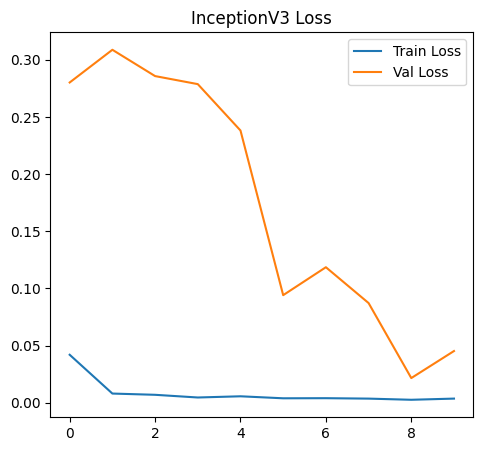

In [17]:
print("Training InceptionV3 regression model...")
history_inception = inception_regression.fit(X_train_inception, y_train, validation_data=(X_val_inception, y_val), epochs=10, batch_size=16)

inception_loss, inception_mae = inception_regression.evaluate(X_val_inception, y_val)

print(f"InceptionV3 - Loss: {inception_loss}, Acc: {inception_mae}")

plot_training_history(history_inception, "InceptionV3")

# ResNet

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.layers import Dense

images_resnet = preprocess_images(image_paths, model_type="resnet")

resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

resnet_regression = build_regression_model(resnet_model, "ResNet50_Regression")

resnet_regression.build((None, 224, 224, 3))
resnet_regression.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)

X_train_resnet, X_val_resnet= train_test_split(images_resnet, test_size=0.2, random_state=42)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training ResNet50 regression model...
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - loss: 0.0937 - mean_absolute_error: 0.2549 - val_loss: 0.2506 - val_mean_absolute_error: 0.4757
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - loss: 0.0231 - mean_absolute_error: 0.1105 - val_loss: 0.3238 - val_mean_absolute_error: 0.5514
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0100 - mean_absolute_error: 0.0748 - val_loss: 0.3089 - val_mean_absolute_error: 0.5364
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0054 - mean_absolute_error: 0.0553 - val_loss: 0.3089 - val_mean_absolute_error: 0.5364
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0049 - mean_absolute_error: 0.0525 - val_loss: 0.3089 - val_mean_absolute_error: 0.5364
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.0047 - mean_absolute_error: 0.0518 - val_loss: 0.3089 - val_mean_absolute_error: 0.5364
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - loss: 0.0060 - mean_abs

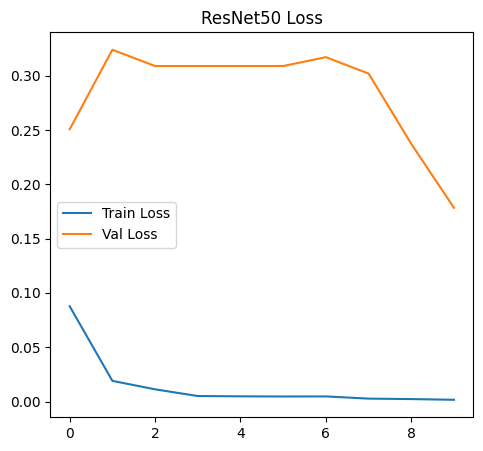

In [19]:
print("Training ResNet50 regression model...")
history_resnet = resnet_regression.fit(X_train_resnet, y_train, validation_data=(X_val_resnet, y_val), epochs=10, batch_size=32)

resnet_loss, resnet_mae = resnet_regression.evaluate(X_val_resnet, y_val)

print(f"ResNet50 - Loss: {resnet_loss}, MAE: {resnet_mae}")

plot_training_history(history_resnet, "ResNet50")